# Lane Line and Road Sign Detection

In [95]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import io
import os
import glob
%matplotlib inline

In [33]:
def binarize(img):
    lower = np.array([0, 150, 150],dtype = "uint8")
    upper = np.array([100, 255, 255],dtype = "uint8")
    mask_y = cv2.inRange(image, lower, upper)

    lower = np.array([100, 100, 100],dtype = "uint8")
    upper = np.array([255, 255, 255],dtype = "uint8")
    mask_w = cv2.inRange(image, lower, upper)

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower = np.array([20, 0, 80], dtype = "uint8")
    upper = np.array([255, 255, 255], dtype = "uint8")
    mask_s = cv2.inRange(hls, lower, upper)

    mask = cv2.bitwise_and(cv2.bitwise_or(mask_y, mask_w), mask_s)

    return mask

In [34]:
def warp_image(img):
    image_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]

    source_points = np.float32([
        [0.117 * x, y],
        [(0.5 * x) - (x*0.078), (2/3)*y],
        [(0.5 * x) + (x*0.078), (2/3)*y],
        [x - (0.117 * x), y]
    ])
    
    destination_points = np.float32([
        [0.25 * x, y],
        [0.25 * x, 0],
        [x - (0.25 * x), 0],
        [x - (0.25 * x), y]
    ])
    
    perspective_transform = cv.getPerspectiveTransform(source_points, destination_points)
    inverse_perspective_transform = cv.getPerspectiveTransform( destination_points, source_points)
    
    warped_img = cv.warpPerspective(img, perspective_transform, image_size, flags=cv.INTER_LINEAR)
    
    return warped_img, inverse_perspective_transform

Text(0.5,1,'Histogram')

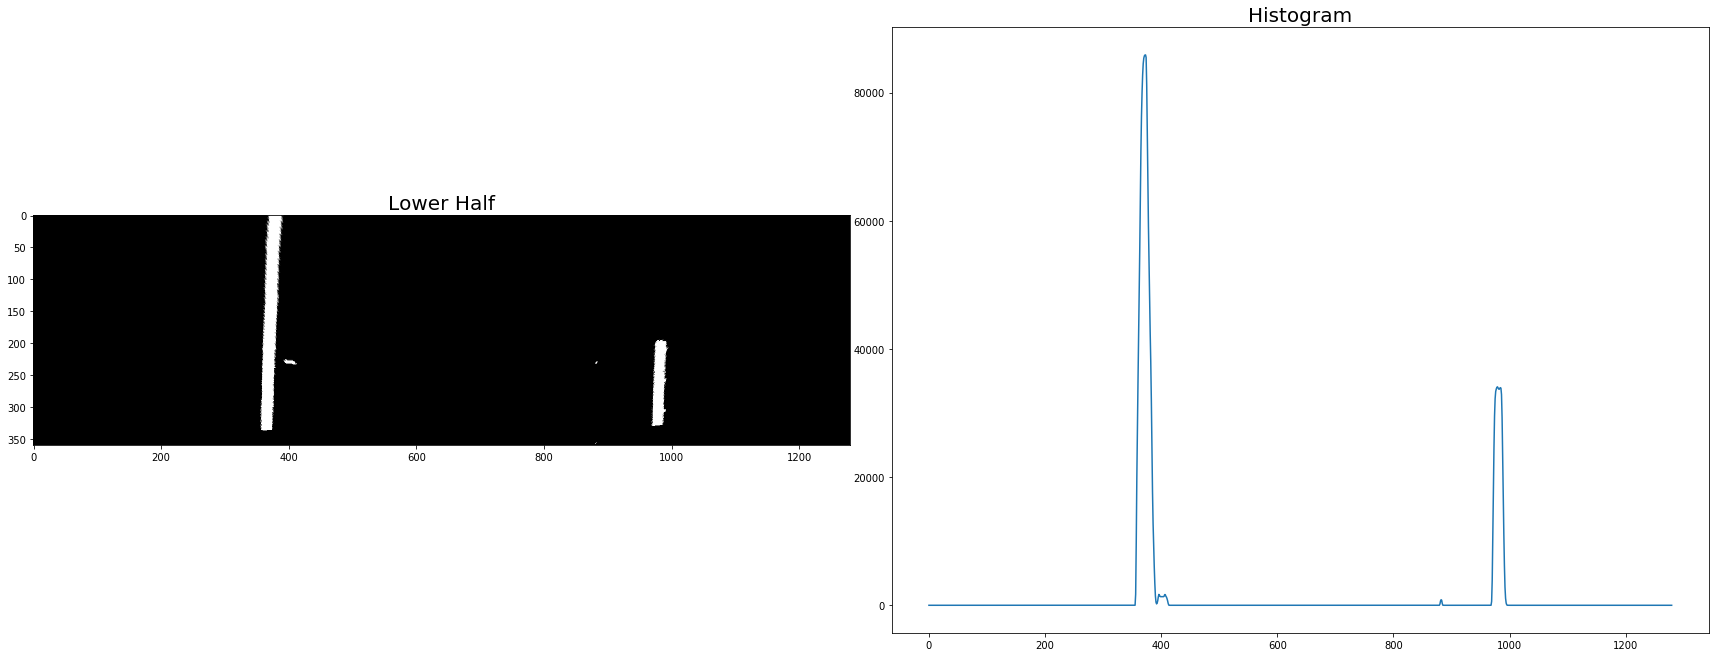

In [84]:
image = cv2.imread('data/v1-0001.png')

bin_img = binarize(image)
M = calculate_transform()
warped_img, inverse_perspective_transform = warp_image(bin_img)

histogram = np.sum(warped_img[int(warped_img.shape[0]/2):,:], axis=0)

lower_half = warped_img[int(warped_img.shape[0]/2):, :]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(lower_half, cmap='gray')
ax1.set_title('Lower Half', fontsize=20)
ax2.plot(histogram)
ax2.set_title('Histogram', fontsize=20)

In [85]:
out_img = np.dstack((warped_img, warped_img, warped_img))#*255

# convert image to integer arrays
out_img = out_img.astype(np.uint8)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(warped_img.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_img.shape[0] - (window+1)*window_height
    win_y_high = warped_img.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 

    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)


# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# change the colour of nonzero pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]



Text(0.5,1,'Binary Image with Plot Lines')

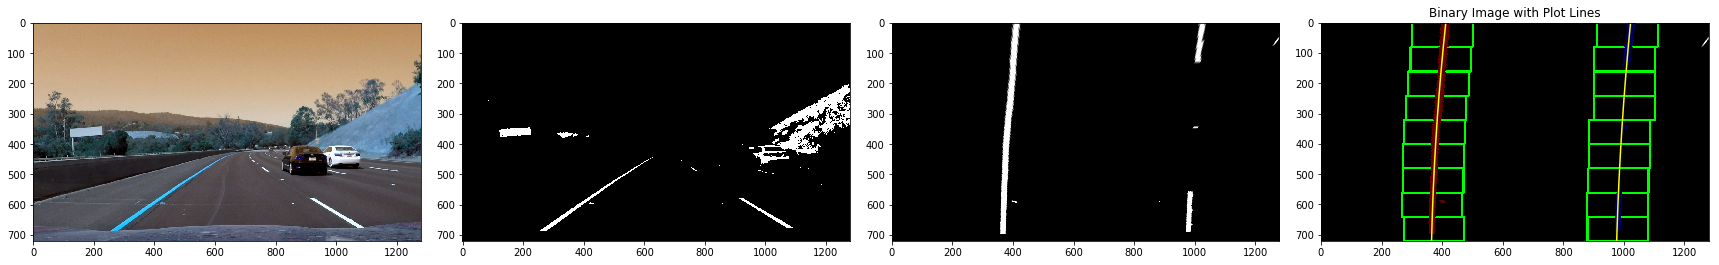

In [89]:
# change the colour of nonzero pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax2.imshow(bin_img, cmap='gray')
ax3.imshow(warped_img, cmap='gray')
# ax1.set_title('Lower Half', fontsize=20)
# ax2.plot(histogram)
# ax2.set_title('Histogram', fontsize=20)

ax4.imshow(out_img.astype(np.uint8))
ax4.plot(left_fitx, ploty, color='yellow')
ax4.plot(right_fitx, ploty, color='yellow')
ax4.set_xlim(0, 1280)
ax4.set_ylim(720, 0)
ax4.set_title('Binary Image with Plot Lines')
# plt.savefig('output_images/plotlines_on_bin_img.jpg')

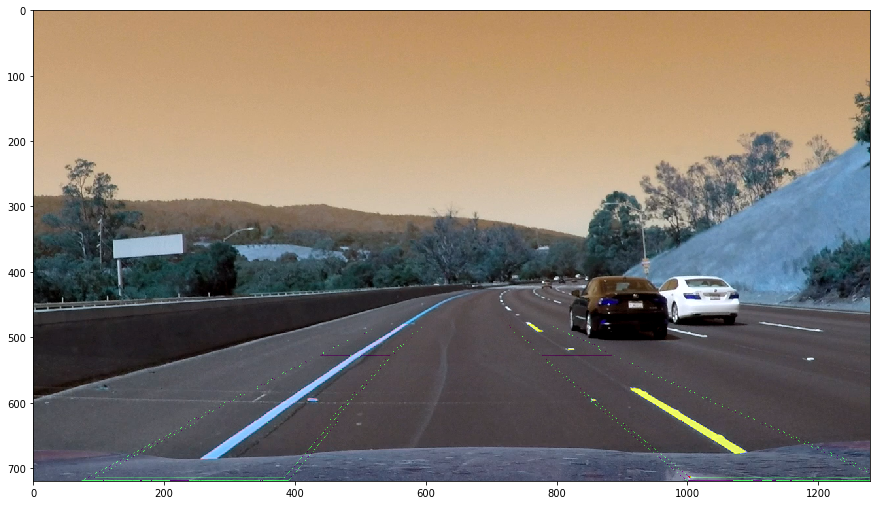

In [94]:
image_size = (out_img.shape[1], out_img.shape[0])
warped_lane = cv.warpPerspective(out_img, inverse_perspective_transform, image_size, flags=cv.INTER_LINEAR)

plt.figure(figsize=(15, 9))
plt.imshow(warped_lane + image)